<a href="https://colab.research.google.com/github/annchirackal/Tensorflow-Developer-Certification/blob/TF_Transfer_Learning/12_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#####What is transfer learning?<br>

we can leverage an existing nueral network architecture proven to work on similar problems which is already learned patterns from dataset  similar  to our own.



Download the data:
we are going to use only 10 percent data, this would help us to understand the powe of transfer learning.

In [ ]:
import tensorflow as tf
import zipfile
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import datetime

import tensorflow_hub as hub
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random



In [ ]:
## Global variables
IMAGE_SHAPE=(224,224)
BATCH_SIZE=32
EPOCHS=5

In [ ]:
 !wget -q https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

In [ ]:
# unzip the loaded file
zip_ref=zipfile.ZipFile("/content/10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
  #lets inspect the directory
for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):

    print(f"{len(filenames)} files and  {len(dirnames)} in directory {dirpath}")


0 files and  2 in directory 10_food_classes_10_percent
0 files and  10 in directory 10_food_classes_10_percent/train
75 files and  0 in directory 10_food_classes_10_percent/train/ice_cream
75 files and  0 in directory 10_food_classes_10_percent/train/ramen
75 files and  0 in directory 10_food_classes_10_percent/train/grilled_salmon
75 files and  0 in directory 10_food_classes_10_percent/train/sushi
75 files and  0 in directory 10_food_classes_10_percent/train/chicken_wings
75 files and  0 in directory 10_food_classes_10_percent/train/pizza
75 files and  0 in directory 10_food_classes_10_percent/train/chicken_curry
75 files and  0 in directory 10_food_classes_10_percent/train/hamburger
75 files and  0 in directory 10_food_classes_10_percent/train/fried_rice
75 files and  0 in directory 10_food_classes_10_percent/train/steak
0 files and  10 in directory 10_food_classes_10_percent/test
250 files and  0 in directory 10_food_classes_10_percent/test/ice_cream
250 files and  0 in directory 10

We have 75 images of each class for traning and 250 from each class for validation

In [ ]:
 #### set the path variables

train_dir="/content/10_food_classes_10_percent/train"
test_dir="/content/10_food_classes_10_percent/test"

train_data_gen=ImageDataGenerator(rescale=1./255,)
test_data_gen=ImageDataGenerator(rescale=1./255,)
print("Traning Images:")
train_data=train_data_gen.flow_from_directory(train_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")
print("Testing Images:")
test_data=train_data_gen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")


Traning Images:
Found 750 images belonging to 10 classes.
Testing Images:
Found 2500 images belonging to 10 classes.


Callbacks are extra functionality you can add to your model to be performed during or after training.Some of the most popular call backs are
- Model check point with the ModelCheckpoint callbacks.
- Tracking experiment with tensor board callbacks.
- Stopping a model from traning with EarlyStopping callbacks.

In [ ]:
#create a tensorboard callbacks

def create_tensorboard_callback(dirname,experiment_name):
  log_dir=dirname+"/"+experiment_name+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir,)
  print(f"Saving TensorBorad log files to {log_dir} ")
  return tensorboard_callback


Creating Models using Tensorflow hub<br>

In previous notebooks we have created custom models from scratch. Here we are creating a model by using layers from pretrained models availble in tensor hub.


In [ ]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [ ]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])

  return model


In [ ]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])


In [ ]:
# Fit the model
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dirname="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log

Saving TensorBorad log files to tensorflow_hub/resnet50V220240222-192945 
Epoch 1/5
24/24 [==============================] - 22s 569ms/step - loss: 2.1014 - accuracy: 0.3133 - val_loss: 1.2659 - val_accuracy: 0.5952
Epoch 2/5
24/24 [==============================] - 10s 433ms/step - loss: 0.9491 - accuracy: 0.7253 - val_loss: 0.8710 - val_accuracy: 0.7196
Epoch 3/5
24/24 [==============================] - 11s 457ms/step - loss: 0.6467 - accuracy: 0.8200 - val_loss: 0.7601 - val_accuracy: 0.7584
Epoch 4/5
24/24 [==============================] - 10s 436ms/step - loss: 0.4865 - accuracy: 0.8720 - val_loss: 0.7271 - val_accuracy: 0.7588
Epoch 5/5
24/24 [==============================] - 11s 491ms/step - loss: 0.3890 - accuracy: 0.9013 - val_loss: 0.6858 - val_accuracy: 0.7752


Eventhouogh we used olnly 10% of the training data, we can see that the model performence increased compared to last one.

In [ ]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

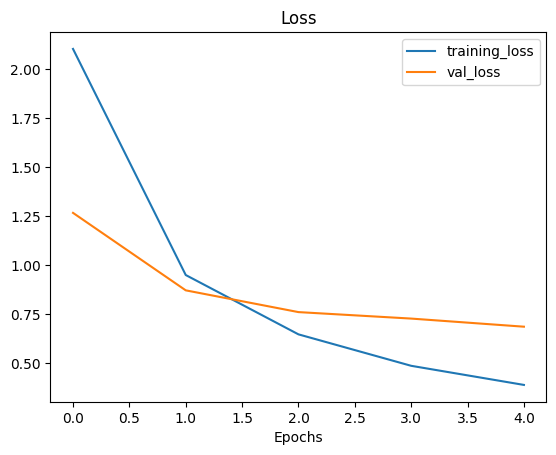

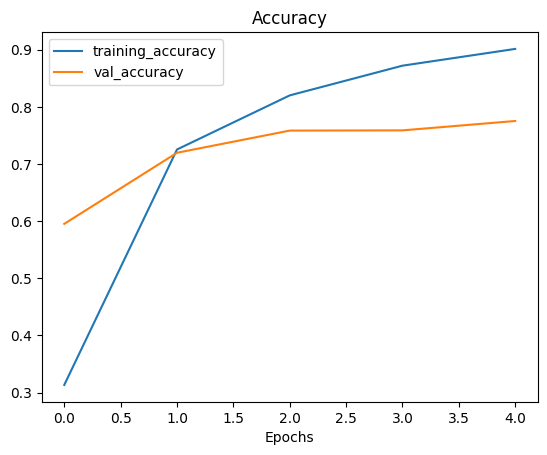

In [ ]:
plot_loss_curves(resnet_history)

In [ ]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
efficientnet_history = efficientnet_model.fit(train_data, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=create_tensorboard_callback(dirname="tensorflow_hub",
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0"))

Saving TensorBorad log files to tensorflow_hub/efficientnetB020240222-193102 
Epoch 1/5
24/24 [==============================] - 24s 556ms/step - loss: 1.8200 - accuracy: 0.4520 - val_loss: 1.2875 - val_accuracy: 0.7308
Epoch 2/5
24/24 [==============================] - 10s 418ms/step - loss: 1.0598 - accuracy: 0.7747 - val_loss: 0.8633 - val_accuracy: 0.8208
Epoch 3/5
24/24 [==============================] - 10s 416ms/step - loss: 0.7595 - accuracy: 0.8280 - val_loss: 0.6986 - val_accuracy: 0.8476
Epoch 4/5
24/24 [==============================] - 9s 399ms/step - loss: 0.6100 - accuracy: 0.8587 - val_loss: 0.6113 - val_accuracy: 0.8604
Epoch 5/5
24/24 [==============================] - 10s 430ms/step - loss: 0.5169 - accuracy: 0.8880 - val_loss: 0.5555 - val_accuracy: 0.8672


# Transfer Learning with Tensorflow - Fine Tuning

In [ ]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2024-02-22 19:32:09--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-22 19:32:09 (105 MB/s) - ‘helper_functions.py’ saved [10246/10246]



###Let's get some data
Now we are going to use inbuild models in tf.keras.applications

In [ ]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-02-22 19:32:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.121.207, 142.250.103.207, 108.177.120.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.121.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   219MB/s    in 0.7s    

2024-02-22 19:32:11 (219 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:

# Walk through 10 percent data directory and list number of files
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [ ]:

# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
 #Create data inputs
import tensorflow as tf
IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:

# Check the training data datatype
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

### Model 0 : Tranfer learnig feature extraction using keras functional API
sequtional API's are straight forward , it passes the data through layers in sequential manner . But functional API gives us more flexibility


In [ ]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# OLD
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)),
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])


24274472/24274472 [==============================] - 0s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20240222-193218
Epoch 1/5
24/24 [==============================] - 16s 233ms/step - loss: 1.8938 - accuracy: 0.4013 - val_loss: 1.3814 - val_accuracy: 0.6694
Epoch 2/5
24/24 [==============================] - 4s 156ms/step - loss: 1.1570 - accuracy: 0.7520 - val_loss: 0.9559 - val_accuracy: 0.7895
Epoch 3/5
24/24 [==============================] - 4s 168ms/step - loss: 0.8361 - accuracy: 0.8147 - val_loss: 0.7426 - val_accuracy: 0.8339
Epoch 4/5
24/24 [==============================] - 4s 137ms/step - loss: 0.6859 - accuracy: 0.8387 - val_loss: 0.6353 - val_accuracy: 0.8618
Epoch 5/5
24/24 [==============================] - 3s 122ms/step - loss: 0.6030 - accuracy: 0.8627 - val_loss: 0.5942 - val_accuracy: 0.8454


In [ ]:

base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [ ]:

# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [ ]:

# Check summary of model constructed with Functional API
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

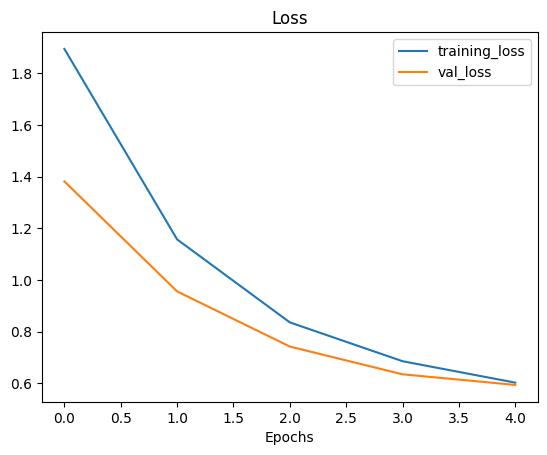

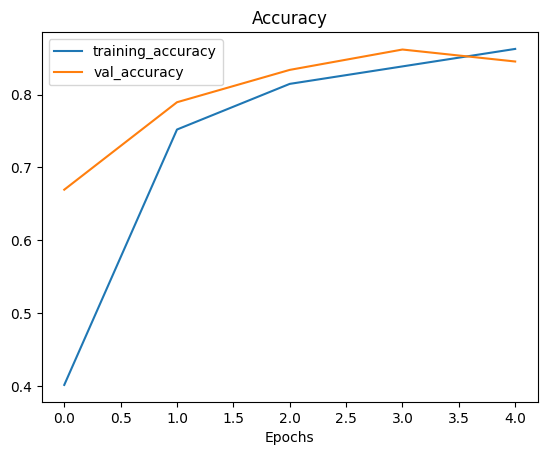

In [ ]:

# Check out our model's training curves
plot_loss_curves(history_10_percent)

In [ ]:
# Define input tensor shape (same number of dimensions as the output of efficientnetv2-b0)
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


#### Lets add a data augmentation layer to the model

In [ ]:
#Create a data augmentation layer
data_augmentation_layer=tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomZoom(0.2)

],name="DataAugmentation_Layer")

In [ ]:
## Visulalise the augmented data
## Get a rodom imange
random_target_class=random.choice(train_data_10_percent.class_names)
random_target_dir="/content/10_food_classes_10_percent/train"+"/"+random_target_class
random_image=random.choice(os.listdir(random_target_dir))
random_target_dir=random_target_dir+"/"+random_image
random_target_dir

'/content/10_food_classes_10_percent/train/ice_cream/2311283.jpg'

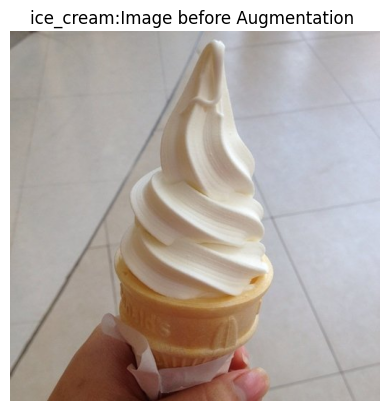

Text(0.5, 1.0, 'ice_cream:Image after Augmentation ')

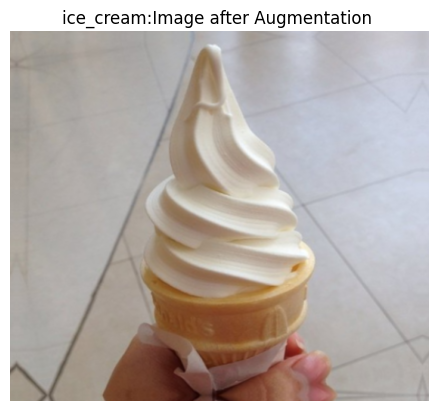

In [ ]:
##Read random image and do augmentation
img=mpimg.imread(random_target_dir)
plt.imshow(img)
plt.axis(False)
plt.title(random_target_class+":Image before Augmentation ")
plt.show()
augmented_img=data_augmentation_layer(img)
plt.imshow(augmented_img/255)

plt.axis(False)
plt.title(random_target_class+":Image after Augmentation ")



In [ ]:
#create  model with data augmentation


base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)



# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

data_augmentation=data_augmentation_layer(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(data_augmentation)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_1 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_1.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
model_1_history_10_percent = model_1.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)),
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])



Shape after base_model: (None, None, None, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20240222-202428
Epoch 1/5
24/24 [==============================] - 29s 729ms/step - loss: 2.0285 - accuracy: 0.3307 - val_loss: 1.5356 - val_accuracy: 0.6118
Epoch 2/5
24/24 [==============================] - 14s 575ms/step - loss: 1.4486 - accuracy: 0.6107 - val_loss: 1.1145 - val_accuracy: 0.7336
Epoch 3/5
24/24 [==============================] - 16s 624ms/step - loss: 1.1386 - accuracy: 0.7387 - val_loss: 0.9051 - val_accuracy: 0.7664
Epoch 4/5
24/24 [==============================] - 15s 591ms/step - loss: 1.0114 - accuracy: 0.7253 - val_loss: 0.7711 - val_accuracy: 0.7911
Epoch 5/5
24/24 [==============================] - 18s 741ms/step - loss: 0.8978 - accuracy: 0.7560 - val_loss: 0.7329 - val_accuracy: 0.7961


In [ ]:
## Check the summary
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 DataAugmentation_Layer (Se  (None, None, 3)           0         
 quential)                                                       
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281